In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer


In [3]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [78]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]
# Nullhypotheses = [
#     "Personal experiences with surveillance cameras do not influence people's views on public monitoring.",
    # "Attitudes toward surveillance cameras are consistent, regardless of their placement.",
    # "Technical complaints about surveillance cameras are rare and there is little demand for enhancements.",
    # "Surveillance cameras make people feel more watched than secure.",
    # "The density of surveillance cameras in an area has no impact on public opinion regarding their presence."
# ]
Nullhypotheses = [
    "Experiences with surveillance systems do not markedly influence public attitudes towards oversight.",
    "Public opinion on monitoring devices is stable across various environments, whether in commercial zones or residential areas.",
    "Issues with monitoring devices are infrequent, with minimal calls for improvements by the populace.",
    "The presence of monitoring systems contributes more to feelings of being observed than to feelings of security.",
    "The prevalence of monitoring systems within a region does not correlate with the community's perception of their utility."
]
# hypotheses = [
#     "People feel that surveillance cameras in public spaces negatively impact their privacy.",
#     "Individuals believe that surveillance cameras effectively reduce crime in their neighborhoods and public areas.",
#     "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
#     "Trust in the organizations that manage surveillance cameras is influenced by specific factors such as transparency and accountability.",
#     "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
#     "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
#     "Surveillance cameras make people feel more secure rather than feeling watched.",
#     "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
# ]

In [79]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...


In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
Nullhypothesis_embeddings = model.encode(Nullhypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/Nullhypothesis_embeddings.pkl', 'wb') as f:
    torch.save(Nullhypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [82]:
# Load saved embeddings
# hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_embeddings.pkl')

In [83]:
column = "thread_text_processed"
# column = "combined_processed"

In [84]:

# texts = df[column].tolist()

# # Generate embeddings in batches
# batch_size = 10000
# embeddings = []

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # Load the SentenceTransformer model and send it to the device
# model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

# for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
#     batch_texts = texts[i:i + batch_size]
#     batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
#     embeddings.append(batch_embeddings)

# # Concatenate all batches
# embeddings = torch.cat(embeddings, dim=0)

# # Save text embeddings
# with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}_embeddings.pkl', 'wb') as f:
#     torch.save(embeddings, f)

In [85]:
# Load saved embeddings
embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}_embeddings.pkl')

In [86]:
# Calculate cosine similarity between text and hypothesis embeddings
# thread_text_similarity_scores = torch.mm(thread_text_embeddings, hypothesis_embeddings.T).cpu().numpy()
similarity_scores = torch.mm(embeddings, hypothesis_embeddings.T).cpu().numpy()

# Save similarity scores
# with open('thread_text_similarity_scores.pkl', 'wb') as f:
#     pickle.dump(thread_text_similarity_scores, f)
# Save similarity scores
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}_similarity_scores.pkl', 'wb') as f:
    pickle.dump(similarity_scores, f)

In [87]:
# Calculate cosine similarity between text and hypothesis embeddings
# thread_text_similarity_scores = torch.mm(thread_text_embeddings, hypothesis_embeddings.T).cpu().numpy()
similarity_scoresNull = torch.mm(embeddings, Nullhypothesis_embeddings.T).cpu().numpy()

# Save similarity scores
# with open('thread_text_similarity_scores.pkl', 'wb') as f:
#     pickle.dump(thread_text_similarity_scores, f)
# Save similarity scores
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}_similarity_scoresNull.pkl', 'wb') as f:
    pickle.dump(similarity_scoresNull, f)

In [88]:
# with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}_similarity_scores.pkl', 'rb') as f:
    # similarity_scores = pickle.load(f)

c:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


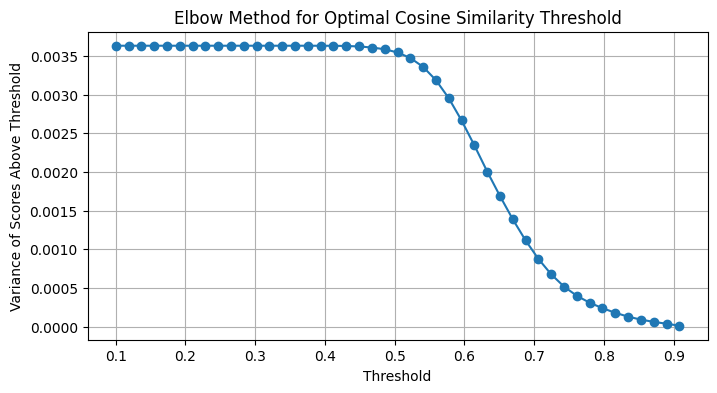

In [89]:
# Assuming 'similarity_scores' is a 2D array where each row corresponds to a document and each column to a hypothesis
thresholds = np.linspace(0.1, 1, 50)  # Adjust as needed for your range of similarity scores
variances = []

for threshold in thresholds:
    filtered_scores = similarity_scores[similarity_scores > threshold]
    variance = np.var(filtered_scores)
    variances.append(variance)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(thresholds, variances, marker='o')
plt.title('Elbow Method for Optimal Cosine Similarity Threshold')
plt.xlabel('Threshold')
plt.ylabel('Variance of Scores Above Threshold')
plt.grid(True)
plt.show()


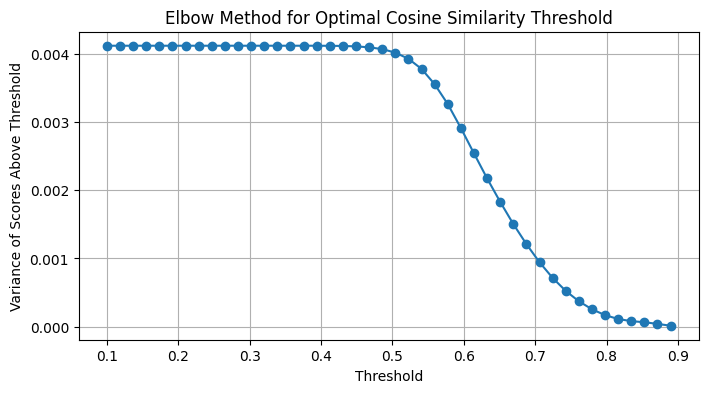

In [90]:
# Assuming 'similarity_scores' is a 2D array where each row corresponds to a document and each column to a hypothesis
thresholds = np.linspace(0.1, 1, 50)  # Adjust as needed for your range of similarity scores
variances = []

for threshold in thresholds:
    filtered_scores = similarity_scoresNull[similarity_scoresNull > threshold]
    variance = np.var(filtered_scores)
    variances.append(variance)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(thresholds, variances, marker='o')
plt.title('Elbow Method for Optimal Cosine Similarity Threshold')
plt.xlabel('Threshold')
plt.ylabel('Variance of Scores Above Threshold')
plt.grid(True)
plt.show()


In [91]:
threshold = 0.6
max_scores = np.max(similarity_scores, axis=1)
df_temp = pd.DataFrame()
df_temp['Max_Similarity_Score'] = max_scores
df_temp['classified'] = df_temp['Max_Similarity_Score'] >= threshold

# Count classified and unclassified
classified_count = df_temp['classified'].sum()
unclassified_count = (~df_temp['classified']).sum()

print(f"Classified Rows: {classified_count}")
print(f"Unclassified Rows: {unclassified_count}")

max_scores = np.max(similarity_scoresNull, axis=1)
df_temp = pd.DataFrame()
df_temp['Max_Similarity_Score'] = max_scores
df_temp['classified'] = df_temp['Max_Similarity_Score'] >= threshold

# Count classified and unclassified
classified_count = df_temp['classified'].sum()
unclassified_count = (~df_temp['classified']).sum()

print(f"Classified Rows: {classified_count}")
print(f"Unclassified Rows: {unclassified_count}")

Classified Rows: 566830
Unclassified Rows: 16941
Classified Rows: 562526
Unclassified Rows: 21245


In [102]:
threshold = 0.7
max_indices = np.argmax(similarity_scores, axis=1)  # Indices of max similarity score per row
max_scores = np.max(similarity_scores, axis=1)  # Max scores per row

# Map indices to hypothesis labels if score exceeds threshold, else assign -1
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[idx] if score > threshold else -1 for idx, score in zip(max_indices, max_scores)]

# threshold = 0.5
max_indices = np.argmax(similarity_scoresNull, axis=1)  # Indices of max similarity score per row
max_scores = np.max(similarity_scoresNull, axis=1)  # Max scores per row

# Map indices to hypothesis labels if score exceeds threshold, else assign -1
hypothesis_labels = {i: f'H{i}' for i in range(len(Nullhypotheses))}
df['Nullhypothesis'] = [hypothesis_labels[idx] if score > threshold else -1 for idx, score in zip(max_indices, max_scores)]

In [103]:
counts_hypothesis = df['hypothesis'].value_counts()
counts_null_hypothesis = df['Nullhypothesis'].value_counts()

print(counts_hypothesis)
print(counts_null_hypothesis)

# Define hypotheses and null hypotheses
hypotheses_identifiers = ['H0', 'H1', 'H2', 'H3', 'H4']
null_hypotheses_identifiers = ['H0', 'H1', 'H2', 'H3', 'H4']
# hypotheses_identifiers = ['H0', 'H1']
# null_hypotheses_identifiers = ['H0', 'H1']

# Initialize results dictionary
results = {}
total_unique_original = 0
total_unique_null = 0

# Calculate overlaps and uniqueness for each hypothesis and its corresponding null hypothesis
for i, hypothesis in enumerate(hypotheses_identifiers):
    for j, null_hypothesis in enumerate(null_hypotheses_identifiers):
        overlap = df[(df['hypothesis'] == hypothesis) & (df['Nullhypothesis'] == null_hypothesis)]
        unique_original = df[(df['hypothesis'] == hypothesis) & (df['Nullhypothesis'] == -1)]
        unique_null = df[(df['hypothesis'] == -1) & (df['Nullhypothesis'] == null_hypothesis)]

        total_unique_original += len(unique_original)
        total_unique_null += len(unique_null)

        results[f'Overlap {hypothesis} with Null {null_hypothesis}'] = len(overlap)
        results[f'Unique to Original {hypothesis}'] = len(unique_original)
        results[f'Unique to Null {null_hypothesis}'] = len(unique_null)

total_rows = len(df)
ununique_original = total_rows - total_unique_original
ununique_null = total_rows - total_unique_null

print("\ntotal_rows: ", total_rows)
print("Ununique (non-unique) counts for Original Hypotheses:", ununique_original)
print("Ununique (non-unique) counts for Null Hypotheses:", ununique_null)

# Print the results in an organized manner
print("\nUnique counts to Original Hypotheses:")
for hypothesis in hypotheses_identifiers:
    print(f"  {hypothesis}: {results[f'Unique to Original {hypothesis}']}")

print("\nUnique counts to Null Hypotheses:")
for null_hypothesis in null_hypotheses_identifiers:
    print(f"  {null_hypothesis}: {results[f'Unique to Null {null_hypothesis}']}")

print("\nOverlaps between Hypotheses and Null Hypotheses:")
for i, hypothesis in enumerate(hypotheses_identifiers):
    print('\n')
    for j, null_hypothesis in enumerate(null_hypotheses_identifiers):
        print(f"  {hypothesis} with {null_hypothesis}: {results[f'Overlap {hypothesis} with Null {null_hypothesis}']}")

hypothesis
-1    181191
H3    118191
H2    117672
H0     68689
H1     60222
H4     37806
Name: count, dtype: int64
Nullhypothesis
H2    194597
-1    173725
H3     84567
H1     47231
H4     44722
H0     38929
Name: count, dtype: int64

total_rows:  583771
Ununique (non-unique) counts for Original Hypotheses: 461026
Ununique (non-unique) counts for Null Hypotheses: 423696

Unique counts to Original Hypotheses:
  H0: 1933
  H1: 4144
  H2: 4026
  H3: 13155
  H4: 1291

Unique counts to Null Hypotheses:
  H0: 1335
  H1: 2959
  H2: 17078
  H3: 4905
  H4: 5738

Overlaps between Hypotheses and Null Hypotheses:


  H0 with H0: 12609
  H0 with H1: 5950
  H0 with H2: 27823
  H0 with H3: 14445
  H0 with H4: 5929


  H1 with H0: 2403
  H1 with H1: 15662
  H1 with H2: 17700
  H1 with H3: 6607
  H1 with H4: 13706


  H2 with H0: 3606
  H2 with H1: 7398
  H2 with H2: 93492
  H2 with H3: 4998
  H2 with H4: 4152


  H3 with H0: 14354
  H3 with H1: 7624
  H3 with H2: 29768
  H3 with H3: 50251
  H3 with H4

In [81]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses_null.csv', index=False)

hypothesis
H0    583164
-1       607
Name: count, dtype: int64


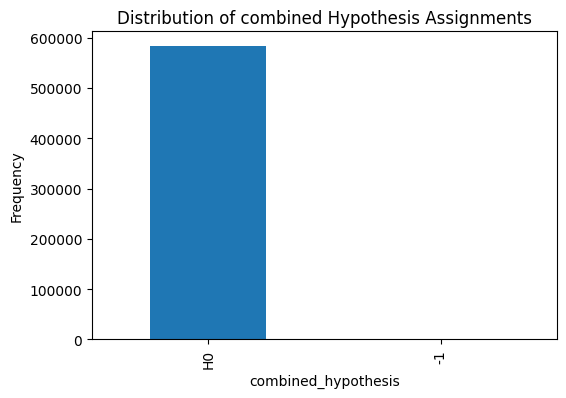

Nullhypothesis
H0    583275
-1       496
Name: count, dtype: int64


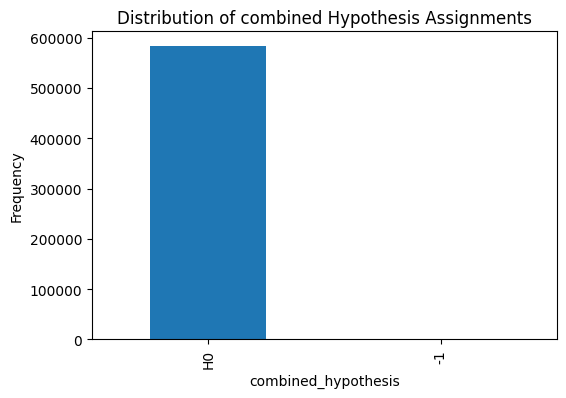

In [39]:
# Optional: Display a histogram of the assigned hypotheses
print(df['hypothesis'].value_counts())
df['hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of combined Hypothesis Assignments')
plt.xlabel('combined_hypothesis')
plt.ylabel('Frequency')
plt.show()

# Optional: Display a histogram of the assigned hypotheses
print(df['Nullhypothesis'].value_counts())
df['Nullhypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of combined Hypothesis Assignments')
plt.xlabel('combined_hypothesis')
plt.ylabel('Frequency')
plt.show()

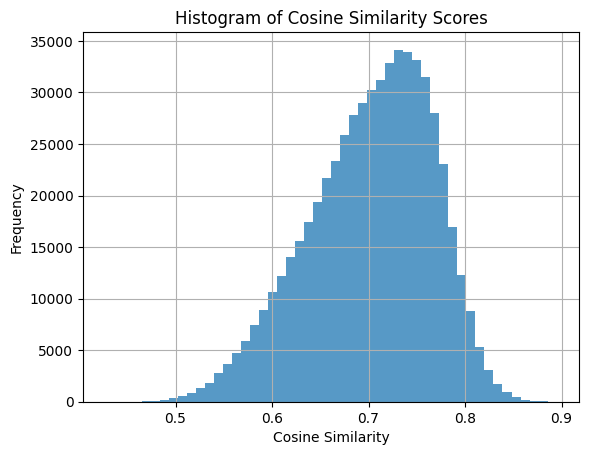

In [40]:
# Assuming `similarity_scores` is a numpy array of your cosine similarity scores
plt.hist(combined_similarity_scores, bins=50, alpha=0.75)
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [43]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,hypothesis,Nullhypothesis
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,-1,-1
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,H0,-1
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,-1,-1
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,-1,-1
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,H0,H0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,H0,H0
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,-1,-1
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,-1,-1
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,-1,-1
